## Get data from bucket

In [2]:
import boto3
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

In [3]:
# Define your S3 bucket and the image key
bucket_name = 'mkorphi-uibk-1'
image_key = 'cropped_images_noaugm_TrainValTest_balanced/train/loose/2011-02-02 bavaria (18)_1.jpg'

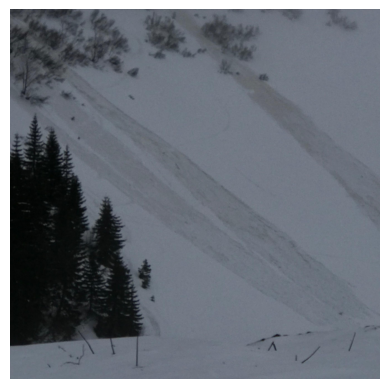

In [4]:
# Initialize a session using Amazon S3
s3 = boto3.client('s3')

# Get the image from S3
response = s3.get_object(Bucket=bucket_name, Key=image_key)
image_data = response['Body'].read()

# Open the image
image = Image.open(BytesIO(image_data))

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

### Train Model

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
import boto3
import os

2024-07-13 03:39:24.093961: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 03:39:24.209740: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-07-13 03:39:24.210371: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-07-13 03:39:24.210543: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-1

In [6]:
print(tf.__version__)

2.11.0


In [7]:
# Set the S3 bucket paths
# Set up the S3 bucket paths
s3_bucket = 'mkorphi-uibk-1'
s3_directory_key = 'cropped_images_noaugm_TrainValTest_balanced'
s3_train ='cropped_images_noaugm_TrainValTest_balanced/train'
s3_val = 'cropped_images_noaugm_TrainValTest_balanced/val'
s3_test = 'cropped_images_noaugm_TrainValTest_balanced/test'

In [8]:
# Local directory to save images
local_directory = 'local_image_directory'

# Create the local directory if it doesn't exist
if not os.path.exists(local_directory):
    os.makedirs(local_directory)


In [9]:
# Local Directory paths
local_directory = 'local_image_directory'
local_train = os.path.join(local_directory, 'train')
local_val =  os.path.join(local_directory, 'val')
local_test =  os.path.join(local_directory, 'test')

In [ ]:
#### DO NOT RUN
# this cell was to get files in the local directory from the s3 bucket

In [10]:
# Function to load datasets
def load_datasets(train_dir, val_dir, test_dir, img_size=(224, 224), batch_size=32):
    train_dataset = image_dataset_from_directory(
        train_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=True
    )
    
    val_dataset = image_dataset_from_directory(
        val_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )
    
    test_dataset = image_dataset_from_directory(
        test_dir,
        labels='inferred',
        label_mode='int',
        batch_size=batch_size,
        image_size=img_size,
        shuffle=False
    )
    
    return train_dataset, val_dataset, test_dataset

In [11]:
# Load datasets
train_dataset, val_dataset, test_dataset = load_datasets(local_train, local_val, local_test)

Found 3504 files belonging to 3 classes.


2024-07-13 03:39:47.020559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-13 03:39:47.030749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-13 03:39:47.032381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-13 03:39:47.034694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F AVX512_VNNI
To enable them in other operations, rebu

Found 879 files belonging to 3 classes.
Found 1098 files belonging to 3 classes.


In [12]:
# Function to build the model
def build_model(num_classes):
    base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    return model


In [28]:
# Build the model
num_classes = len(train_dataset.class_names)
model = build_model(num_classes)

# Compile the model
model.compile(optimizer=Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/EfficientNetV2S_best_model_2',  # specify the directory to save the model
    monitor='val_accuracy',                        # monitor validation accuracy
    save_best_only=True,                           # save only the best model
    mode='max',                                    # mode should be 'max' for accuracy
    save_weights_only=False,                       # set to False to save the entire model
    verbose=1                                      # verbosity mode, 1 for progress bar
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=val_dataset,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)


Epoch 1/40


2024-07-13 03:47:37.441552: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - ETA: 0s - loss: 1.5287 - accuracy: 0.5739
Epoch 1: val_accuracy improved from -inf to 0.69397, saving model to models/EfficientNetV2S_best_model_2


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 111s 895ms/step - loss: 1.5287 - accuracy: 0.5739 - val_loss: 0.7364 - val_accuracy: 0.6940 - lr: 0.0010
Epoch 2/40
110/110 [==============================] - ETA: 0s - loss: 1.1764 - accuracy: 0.6293
Epoch 2: val_accuracy improved from 0.69397 to 0.71445, saving model to models/EfficientNetV2S_best_model_2


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 96s 872ms/step - loss: 1.1764 - accuracy: 0.6293 - val_loss: 0.6877 - val_accuracy: 0.7144 - lr: 0.0010
Epoch 3/40
110/110 [==============================] - ETA: 0s - loss: 1.0140 - accuracy: 0.6461
Epoch 3: val_accuracy improved from 0.71445 to 0.71559, saving model to models/EfficientNetV2S_best_model_2


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 96s 869ms/step - loss: 1.0140 - accuracy: 0.6461 - val_loss: 0.6584 - val_accuracy: 0.7156 - lr: 0.0010
Epoch 4/40
110/110 [==============================] - ETA: 0s - loss: 0.8736 - accuracy: 0.6698
Epoch 4: val_accuracy improved from 0.71559 to 0.74858, saving model to models/EfficientNetV2S_best_model_2


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 97s 873ms/step - loss: 0.8736 - accuracy: 0.6698 - val_loss: 0.6315 - val_accuracy: 0.7486 - lr: 0.0010
Epoch 5/40
110/110 [==============================] - ETA: 0s - loss: 0.8375 - accuracy: 0.6672
Epoch 5: val_accuracy improved from 0.74858 to 0.75768, saving model to models/EfficientNetV2S_best_model_2


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 97s 880ms/step - loss: 0.8375 - accuracy: 0.6672 - val_loss: 0.6001 - val_accuracy: 0.7577 - lr: 0.0010
Epoch 6/40
110/110 [==============================] - ETA: 0s - loss: 0.7717 - accuracy: 0.6909
Epoch 6: val_accuracy did not improve from 0.75768
110/110 [==============================] - 23s 197ms/step - loss: 0.7717 - accuracy: 0.6909 - val_loss: 0.6371 - val_accuracy: 0.7565 - lr: 0.0010
Epoch 7/40
110/110 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.6844
Epoch 7: val_accuracy did not improve from 0.75768
110/110 [==============================] - 23s 199ms/step - loss: 0.7600 - accuracy: 0.6844 - val_loss: 0.6202 - val_accuracy: 0.7395 - lr: 0.0010
Epoch 8/40
110/110 [==============================] - ETA: 0s - loss: 0.7547 - accuracy: 0.6884
Epoch 8: val_accuracy did not improve from 0.75768
110/110 [==============================] - 23s 200ms/step - loss: 0.7547 - accuracy: 0.6884 - val_loss: 0.6293 - val_a

INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 98s 882ms/step - loss: 0.6632 - accuracy: 0.7320 - val_loss: 0.5875 - val_accuracy: 0.7747 - lr: 2.0000e-04
Epoch 10/40
110/110 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.7412
Epoch 10: val_accuracy did not improve from 0.77474
110/110 [==============================] - 23s 201ms/step - loss: 0.6285 - accuracy: 0.7412 - val_loss: 0.5772 - val_accuracy: 0.7713 - lr: 2.0000e-04
Epoch 11/40
110/110 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.7334
Epoch 11: val_accuracy did not improve from 0.77474
110/110 [==============================] - 23s 199ms/step - loss: 0.6327 - accuracy: 0.7334 - val_loss: 0.5792 - val_accuracy: 0.7702 - lr: 2.0000e-04
Epoch 12/40
110/110 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.7317
Epoch 12: val_accuracy did not improve from 0.77474
110/110 [==============================] - 23s 198ms/step - loss: 0.6274 - accuracy: 0.7317 - val_lo

INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 96s 869ms/step - loss: 0.5986 - accuracy: 0.7514 - val_loss: 0.5761 - val_accuracy: 0.7793 - lr: 2.0000e-04
Epoch 14/40
110/110 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.7489
Epoch 14: val_accuracy did not improve from 0.77929
110/110 [==============================] - 23s 201ms/step - loss: 0.6100 - accuracy: 0.7489 - val_loss: 0.5725 - val_accuracy: 0.7759 - lr: 2.0000e-04
Epoch 15/40
110/110 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.7489
Epoch 15: val_accuracy improved from 0.77929 to 0.78157, saving model to models/EfficientNetV2S_best_model_2


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 97s 875ms/step - loss: 0.6010 - accuracy: 0.7489 - val_loss: 0.5735 - val_accuracy: 0.7816 - lr: 2.0000e-04
Epoch 16/40
110/110 [==============================] - ETA: 0s - loss: 0.5857 - accuracy: 0.7586
Epoch 16: val_accuracy improved from 0.78157 to 0.78612, saving model to models/EfficientNetV2S_best_model_2


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 97s 881ms/step - loss: 0.5857 - accuracy: 0.7586 - val_loss: 0.5620 - val_accuracy: 0.7861 - lr: 2.0000e-04
Epoch 17/40
110/110 [==============================] - ETA: 0s - loss: 0.5931 - accuracy: 0.7526
Epoch 17: val_accuracy did not improve from 0.78612
110/110 [==============================] - 23s 198ms/step - loss: 0.5931 - accuracy: 0.7526 - val_loss: 0.5624 - val_accuracy: 0.7838 - lr: 2.0000e-04
Epoch 18/40
110/110 [==============================] - ETA: 0s - loss: 0.5694 - accuracy: 0.7737
Epoch 18: val_accuracy did not improve from 0.78612
110/110 [==============================] - 23s 198ms/step - loss: 0.5694 - accuracy: 0.7737 - val_loss: 0.5751 - val_accuracy: 0.7759 - lr: 2.0000e-04
Epoch 19/40
110/110 [==============================] - ETA: 0s - loss: 0.5759 - accuracy: 0.7643
Epoch 19: val_accuracy did not improve from 0.78612
110/110 [==============================] - 23s 199ms/step - loss: 0.5759 - accuracy: 0.7643 - val_lo

INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 98s 886ms/step - loss: 0.5457 - accuracy: 0.7717 - val_loss: 0.5525 - val_accuracy: 0.7895 - lr: 1.0000e-04
Epoch 33/40
110/110 [==============================] - ETA: 0s - loss: 0.5096 - accuracy: 0.7982
Epoch 33: val_accuracy did not improve from 0.78953
110/110 [==============================] - 23s 199ms/step - loss: 0.5096 - accuracy: 0.7982 - val_loss: 0.5515 - val_accuracy: 0.7850 - lr: 1.0000e-04
Epoch 34/40
110/110 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.7851
Epoch 34: val_accuracy improved from 0.78953 to 0.79408, saving model to models/EfficientNetV2S_best_model_2


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


INFO:tensorflow:Assets written to: models/EfficientNetV2S_best_model_2/assets


110/110 [==============================] - 96s 872ms/step - loss: 0.5290 - accuracy: 0.7851 - val_loss: 0.5505 - val_accuracy: 0.7941 - lr: 1.0000e-04
Epoch 35/40
110/110 [==============================] - ETA: 0s - loss: 0.5263 - accuracy: 0.7805
Epoch 35: val_accuracy did not improve from 0.79408
110/110 [==============================] - 23s 199ms/step - loss: 0.5263 - accuracy: 0.7805 - val_loss: 0.5526 - val_accuracy: 0.7838 - lr: 1.0000e-04
Epoch 36/40
110/110 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.7948
Epoch 36: val_accuracy did not improve from 0.79408
110/110 [==============================] - 23s 200ms/step - loss: 0.5134 - accuracy: 0.7948 - val_loss: 0.5481 - val_accuracy: 0.7838 - lr: 1.0000e-04
Epoch 37/40
110/110 [==============================] - ETA: 0s - loss: 0.5215 - accuracy: 0.7911
Epoch 37: val_accuracy did not improve from 0.79408
110/110 [==============================] - 23s 199ms/step - loss: 0.5215 - accuracy: 0.7911 - val_lo

In [29]:
print(model)

## Analyze Results

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [31]:
## Load Best Model
best_model = tf.keras.models.load_model('models/EfficientNetV2S_best_model_2')

In [32]:
# Evaluate on test dataset
test_loss, test_acc = best_model.evaluate(test_dataset, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Generate predictions for the test dataset
test_predictions = best_model.predict(test_dataset)
test_predictions = np.argmax(test_predictions, axis=1)

# Extract true labels from the test dataset
test_labels = np.concatenate([y for x, y in test_dataset], axis=0)

35/35 - 10s - loss: 0.5429 - accuracy: 0.7905 - 10s/epoch - 272ms/step

Test accuracy: 0.7905282378196716
35/35 [==============================] - 9s 165ms/step


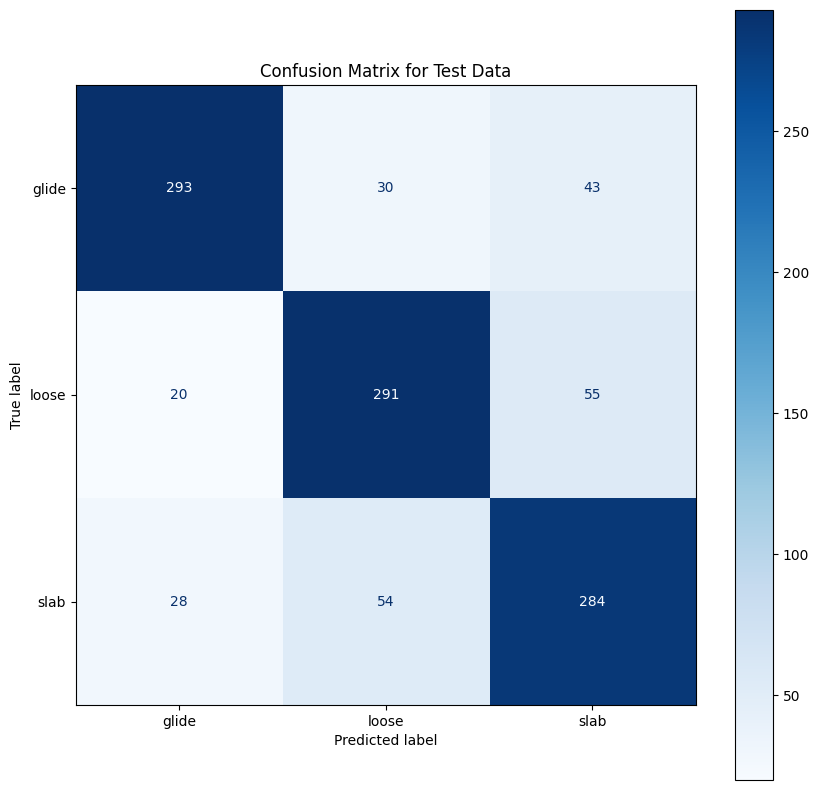

In [33]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Plot the confusion matrix with a customized color map
fig, ax = plt.subplots(figsize=(10, 10))
cmd = ConfusionMatrixDisplay(cm, display_labels=test_dataset.class_names)
cmd.plot(ax=ax, cmap='Blues')  # Use the 'Blues' colormap
plt.title('Confusion Matrix for Test Data')
plt.show()



In [34]:
# Compute the classification report including F1-score
class_report = classification_report(test_labels, test_predictions, target_names=test_dataset.class_names)
print('\nClassification Report:\n', class_report)


Classification Report:
               precision    recall  f1-score   support

       glide       0.86      0.80      0.83       366
       loose       0.78      0.80      0.79       366
        slab       0.74      0.78      0.76       366

    accuracy                           0.79      1098
   macro avg       0.79      0.79      0.79      1098
weighted avg       0.79      0.79      0.79      1098



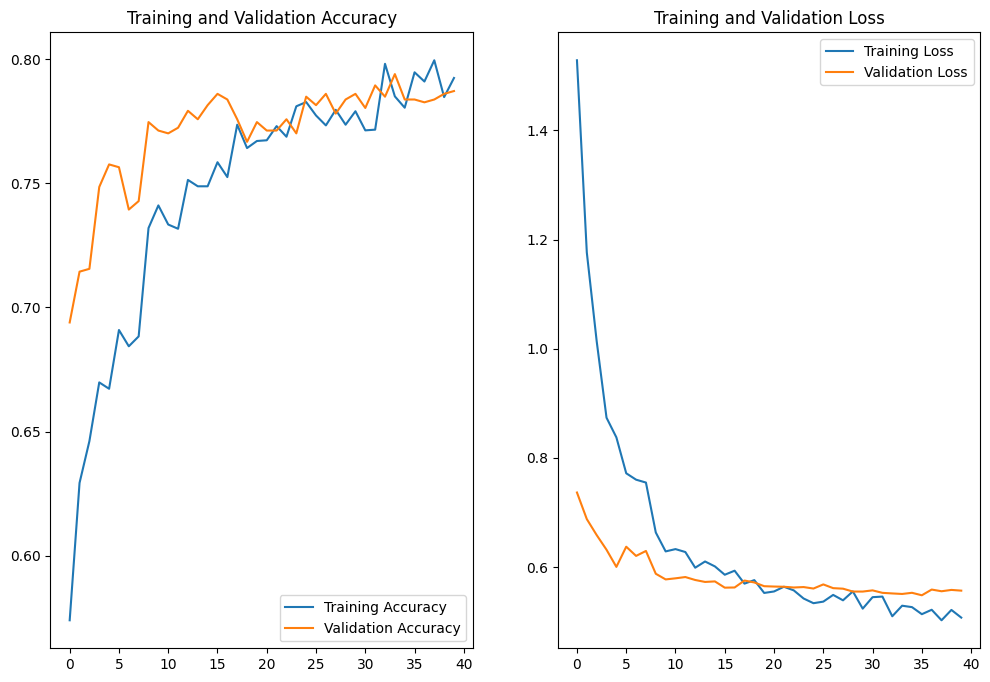

In [35]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # Use the length of the history data to ensure the dimensions match

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Misclassified images

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

In [37]:
# Predict probabilities and classes
predictions = test_predictions
predicted_labels = test_predictions
true_labels = test_labels

In [38]:
# Find indices of misclassified images and categorize them by true and predicted labels
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_images = np.array(list(test_dataset.unbatch().as_numpy_iterator()))[misclassified_indices]
misclassified_true_labels = true_labels[misclassified_indices]
misclassified_predicted_labels = predicted_labels[misclassified_indices]

/tmp/ipykernel_17/2719623181.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  misclassified_images = np.array(list(test_dataset.unbatch().as_numpy_iterator()))[misclassified_indices]


In [39]:
# Create a dictionary to store misclassified images by each true/predicted label pair
misclassified_by_type = {}
for true_label, predicted_label in zip(misclassified_true_labels, misclassified_predicted_labels):
    label_pair = (true_label, predicted_label)
    if label_pair not in misclassified_by_type:
        misclassified_by_type[label_pair] = []

    # Find the corresponding image for this misclassification
    #print(true_label)
    #print(predicted_label)
        indices = np.where((misclassified_true_labels == true_label) & (misclassified_predicted_labels == predicted_label))[0]
        for idx in indices:
            misclassified_by_type[label_pair].append(misclassified_images[idx])
    #print(idx)
        #misclassified_by_type[label_pair].append(misclassified_images[idx])

In [40]:
#Sanity check with confusion matrix
print(len(misclassified_by_type[0,1]))
print(len(misclassified_by_type[0,2]))
print(len(misclassified_by_type[1,0]))
print(len(misclassified_by_type[2,0]))

30
43
20
28


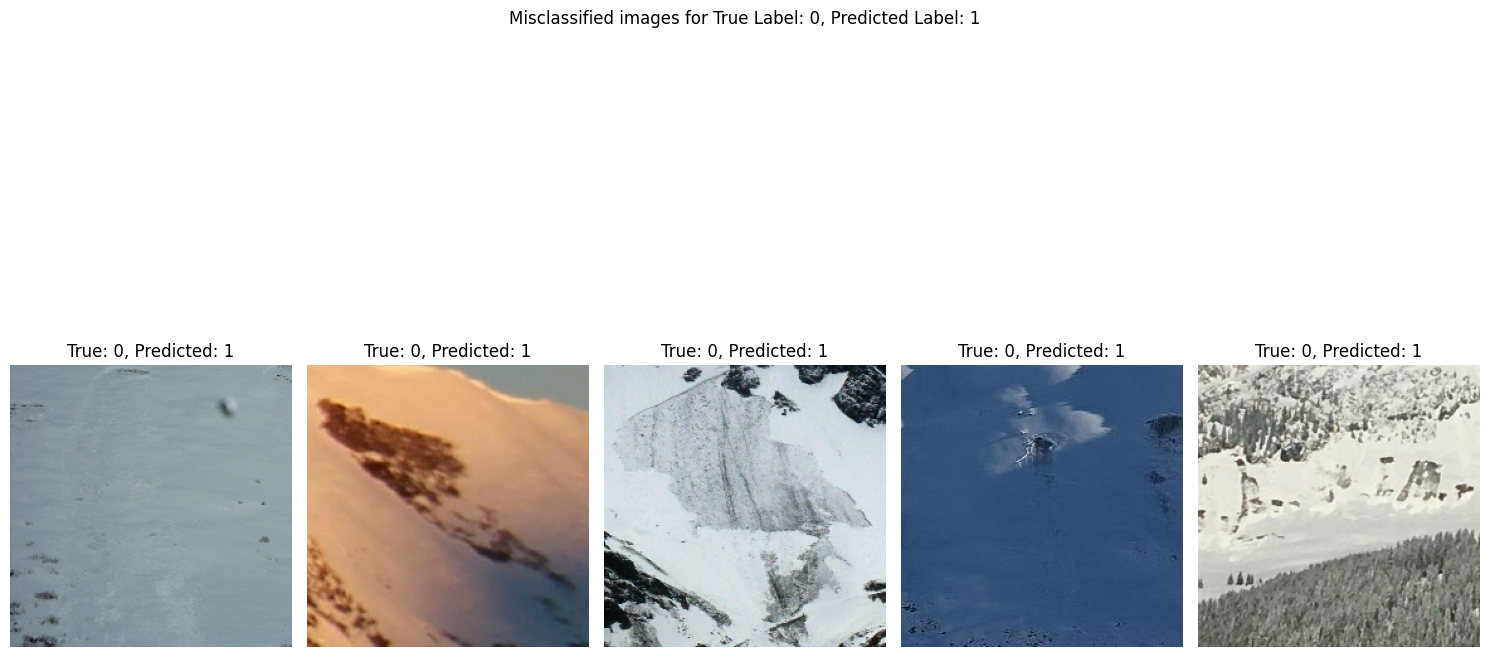

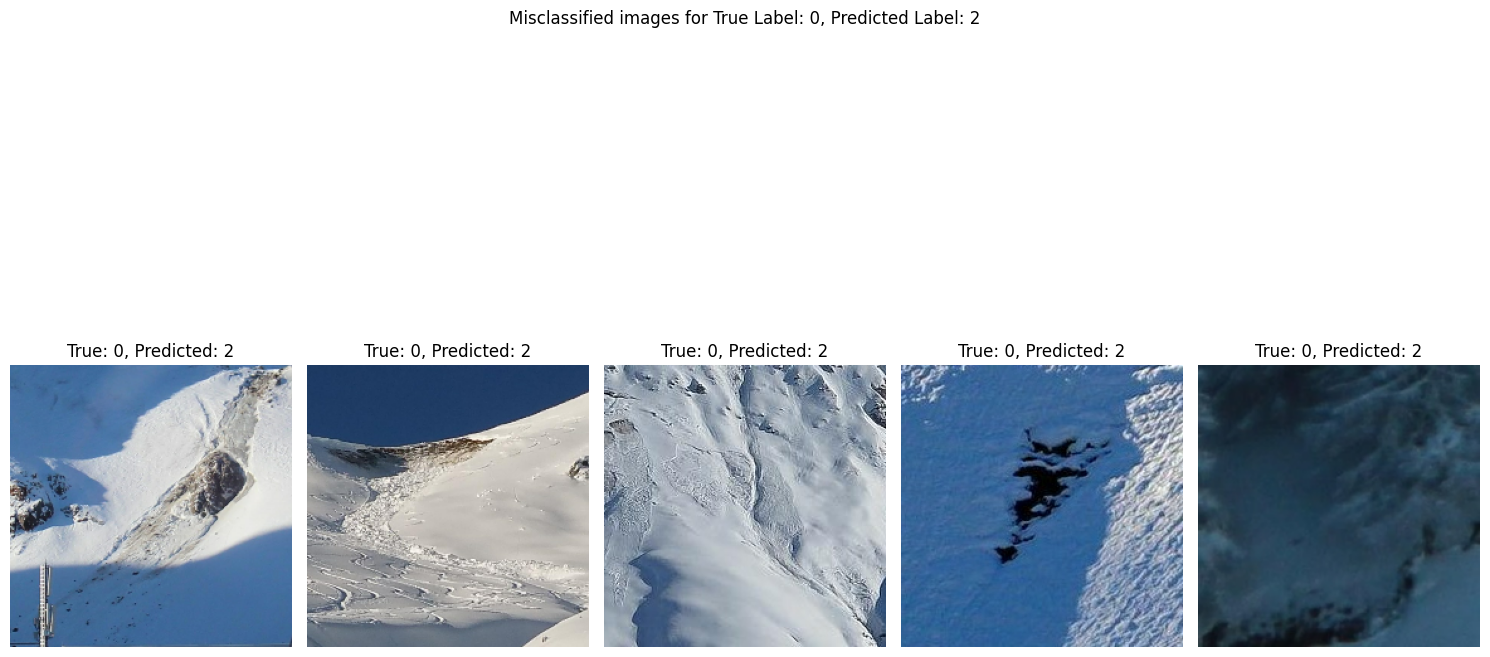

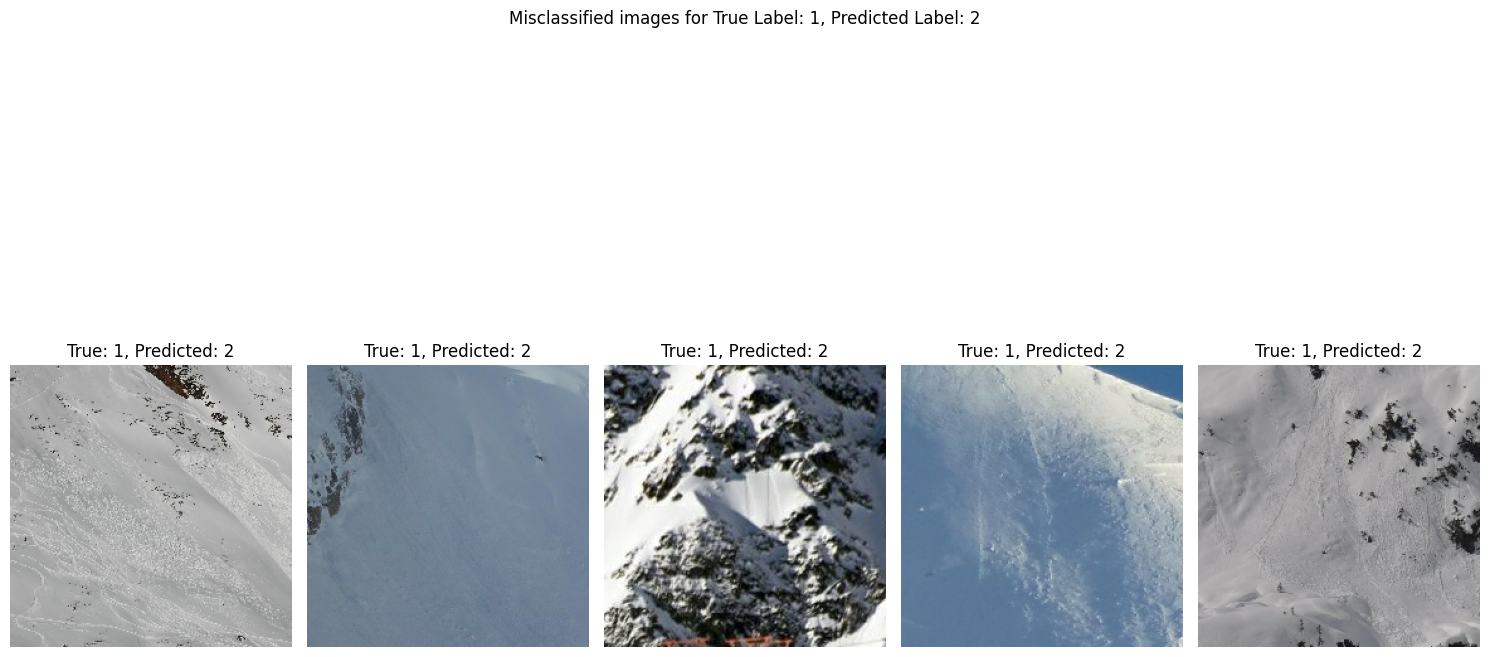

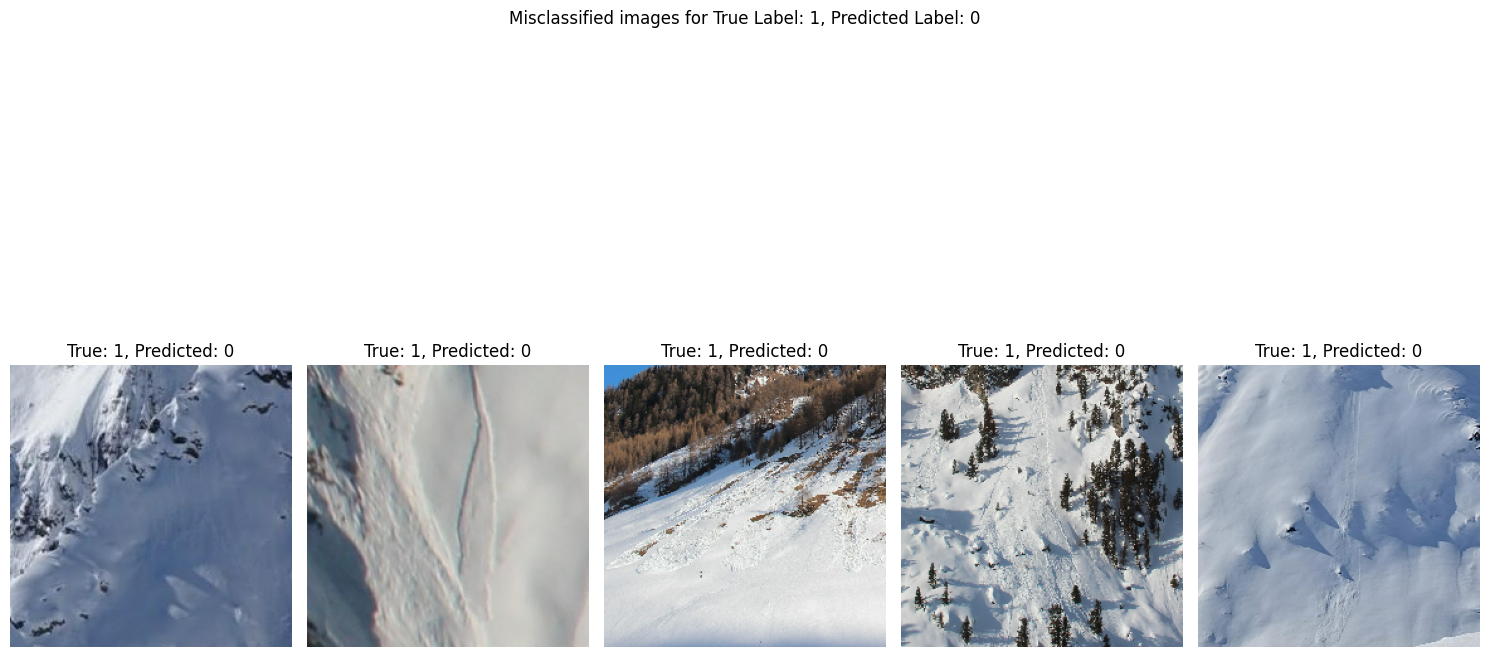

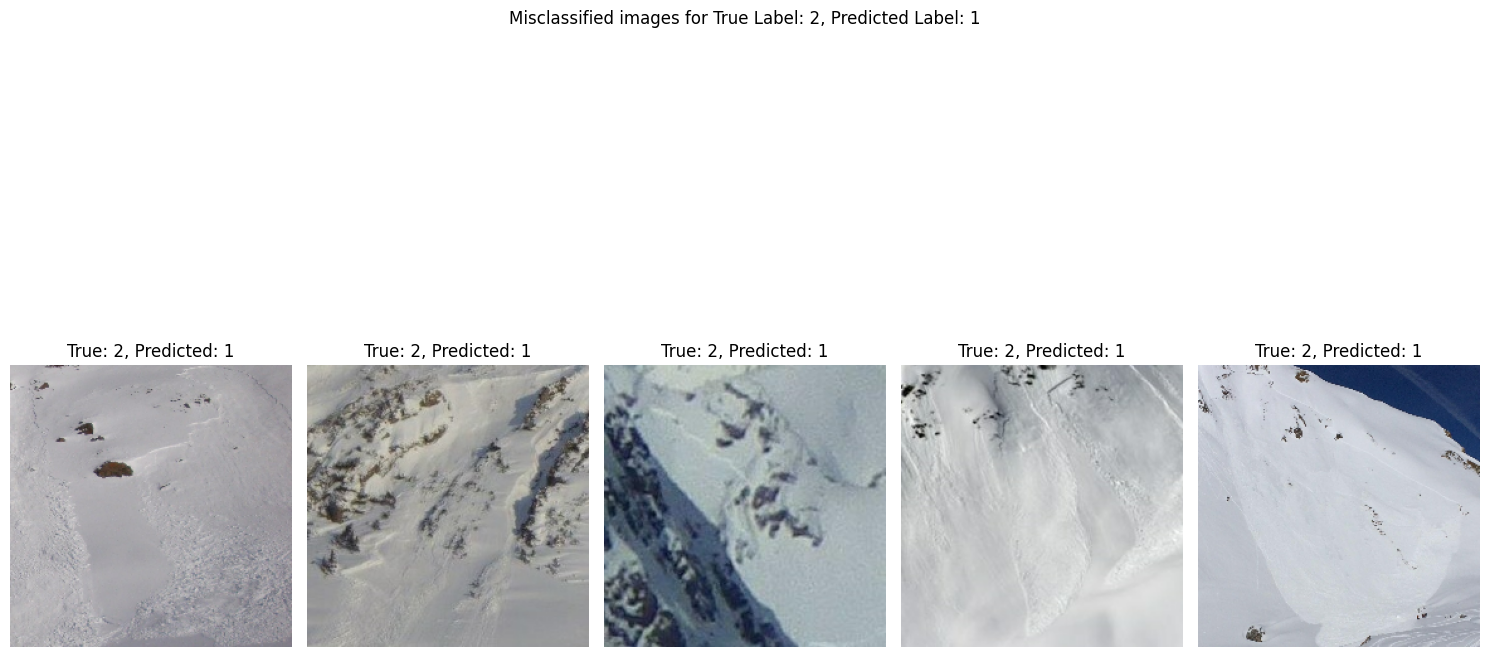

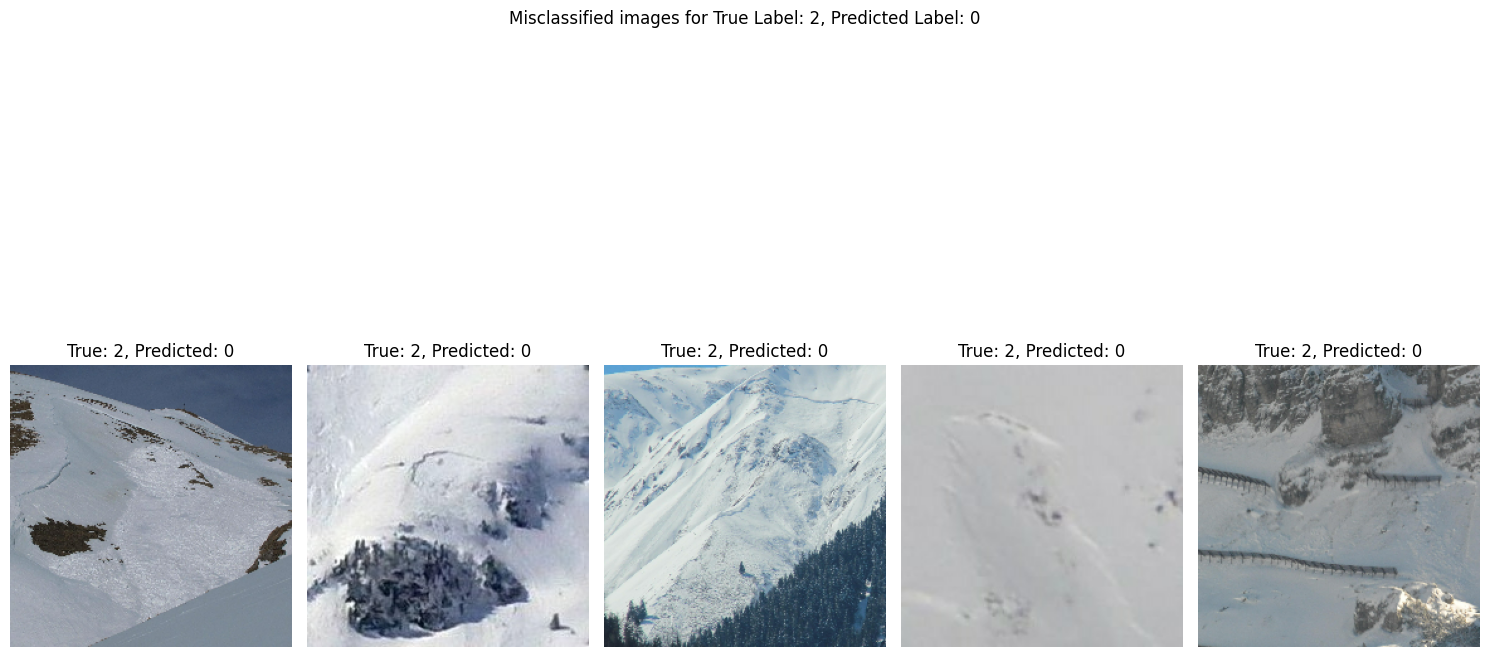

In [41]:
# Visualize misclassified images for each unique true/predicted label pair
num_samples_per_pair = 5  # Number of samples to display per pair
for i, (label_pair, images) in enumerate(misclassified_by_type.items()):
    true_label, predicted_label = label_pair

    plt.figure(figsize=(15, 10))
    for j, image in enumerate(images[:num_samples_per_pair]):
        # Display the image
        plt.subplot(1, num_samples_per_pair, j + 1)
        plt.imshow(image[0].astype(np.uint8))  # Assuming image is in uint8 format
        plt.title(f"True: {true_label}, Predicted: {predicted_label}")
        plt.axis('off')

    plt.suptitle(f"Misclassified images for True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.tight_layout()
    plt.show()